# <span style="color:orange"> *Multiple bounded optimization* </span> 

In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

# <span style="color:lime"> *Repository & Tool loading* </span>
Remember to check that it says the exact commit you should be working on </br>


 ### *This only needs to be run once, then the folder will be created*

In [2]:
%cd susceptibility-to-fieldmap-fft 
!git status
!git checkout d9f785b
%pip install .

c:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt\susceptibility-to-fieldmap-fft


c:\Users\Admin\miniconda3\envs\shazam32\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


Note: switching to 'd9f785b'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at d9f785b Fix bug


Processing c:\users\admin\documents\msc_project\image-processing-strategies\chi_opt\susceptibility-to-fieldmap-fft
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for susceptibility-to-fieldmap-fft: filename=susceptibility_to_fieldmap_fft-0.0.0-py3-none-any.whl size=23317 sha256=d98a4f31257d2f86a81d9ea3bd3d1a8c12a71eda7802f8698f6891c27c874750
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\08\54\fd\2f77d3bbe57c3710ceb388683d1f58b0cbc72178fffcb8b4c4
Successfully built susceptibility-to-fieldmap-fft
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'susceptibility-to-fieldmap-fft' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'susceptibility-to-fieldmap-fft'. Discussion can be found at https://github.com/pypa/pip/issues/6334


### *Load functions for dipole convolution*

In [2]:
home_path = r"C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt"
#Once we confirmed the head of the chi to fbfest we can go to home
%cd {home_path}
!ls

C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt


c:\Users\Admin\miniconda3\envs\shazam_joint_3235\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


chi_demostrator.py
chi_opt_demod_32.ipynb
chi_opt_demod_32_35.ipynb
chi_opt_demod_33.ipynb
chi_opt_demod_35.ipynb
demod.py
normalize_mprage.py
shazam_requirements.txt
susceptibility-to-fieldmap-fft
tissue-to-MRproperty
utils


In [3]:
path_to_chi_to_fm_fft = r"C:\Users\Admin\Documents\msc_project\Image-processing-strategies\chi_opt\susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

# <span style="color:silver"> *Simulation data pre-loading* </span> 

In [4]:
# Define the run nfolder name
run_number = "hybrid_test_fast_for_figures"

In [ ]:
# Everytime you run the code, it will create a new folder with the run number and restart the counter
path_to_iter_fms = r"E:\msc_data\ismrm_2025\joint_opt\32_35_fms\iter_fms"
path_to_iter_metrics = r"E:\msc_data\ismrm_2025\joint_opt\32_35_fms\iter_metrics"

path_to_iter_fms = os.path.join(path_to_iter_fms,run_number)
path_to_iter_metrics = os.path.join(path_to_iter_metrics,run_number)
counter = 0

#########
# This don't change, this are used with the simulation's FOV for each subject
path_to_sim32_metric_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_dmod32_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_chimap32 = "E:/msc_data/ismrm_2025/db0_032/fm/sim/B1_chi_maps/db0_032_sus_opt_map.nii.gz" # -4.2ppm internal air (past value)
path_to_segs32 = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt2/grouped_wb_segs.nii.gz"

path_to_sim35_metric_mask = "E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_dmod35_mask = "E:\msc_data/ismrm_2025/dB0_035/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_chimap35 = "E:\msc_data/ismrm_2025/dB0_035/fm/sim/B1_chi_maps/dB0_035_abs_chi_dist.nii.gz" # -4.36 (past value)
path_to_segs35 = r"E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\final_merged_wb_segs.nii.gz"

 # <span style="color:#ffaa00"> *In-vivo data loading* </span> 

In [6]:
# load it:
db0_032_avg_dmod_metric_values_df = pd.read_csv(r"E:\msc_data\ismrm_2025\db0_032\fm\chi-opt3\dB0_032_avg_dmod_meas_metrics_c5t8.csv")
# crop to use c5 to t7 below

In [7]:
# Check the values:
db0_032_avg_dmod_metric_values = db0_032_avg_dmod_metric_values_df['WA()']
db0_032_avg_dmod_metric_values = db0_032_avg_dmod_metric_values[:-1] # Taking out the last value to have c5 to t7
db0_032_avg_dmod_metric_values

0   -106.139850
1    -53.375568
2     33.069596
3    101.583283
4     69.157018
5    -10.052884
6    -30.909861
7    -11.544327
8     15.742243
9     26.086530
Name: WA(), dtype: float64

In [8]:
db0_032_avg_dmod_metric_values_list = db0_032_avg_dmod_metric_values.tolist()
db0_032_avg_dmod_metric_values_list

[-106.13984974437778,
 -53.375568056251325,
 33.06959584901248,
 101.58328285114206,
 69.15701765557988,
 -10.052884244790928,
 -30.90986093211832,
 -11.544326879652852,
 15.742243465676378,
 26.086530251520543]

In [9]:
# load it:
db0_035_avg_dmod_metric_values_df = pd.read_csv(r"E:\msc_data\ismrm_2025\dB0_035\fm\chi-opt3\dB0_035_avg_dmod_meas_metrics_c3t7.csv")
# crop to use c5 to t7 

In [10]:
# Check the values:
db0_035_avg_dmod_metric_values = db0_035_avg_dmod_metric_values_df['WA()']
db0_035_avg_dmod_metric_values = db0_035_avg_dmod_metric_values[2:] # Taking out the first two values to have c5 to t7
db0_035_avg_dmod_metric_values

2    -74.811855
3    -36.277499
4     23.813495
5     82.638355
6     72.294822
7     48.810360
8     45.322720
9     58.677333
10    59.936366
11    22.478234
Name: WA(), dtype: float64

In [11]:
db0_035_avg_dmod_metric_values_list = db0_035_avg_dmod_metric_values.tolist()
db0_035_avg_dmod_metric_values_list

[-74.81185546139756,
 -36.27749870264742,
 23.81349539390885,
 82.63835481835604,
 72.29482206924526,
 48.81035957570356,
 45.32271982106528,
 58.67733282003319,
 59.93636567686757,
 22.47823357262947]

In [12]:
central_freq_db32 = 123.249521 # in MHz
gamma_bar = 42.58 # MHz/T
# If the central frequency from the scanner is 123.249489 MHz, it meas the B0 strenght we need to simulate is:
B0_used_scan32 = central_freq_db32 /gamma_bar
print("The B0 to use in the db0_032 simulation should be: ", B0_used_scan32, "T")

central_freq_db35 = 123.249391 # in MHz
B0_used_scan35 = central_freq_db35 /gamma_bar
print("The B0 to use in the db0_035 simulation should be: ", B0_used_scan35, "T")

The B0 to use in the db0_032 simulation should be:  2.894540183184594 T
The B0 to use in the db0_035 simulation should be:  2.894537130108032 T


### <span style="color:chocolate"> *In case you want to compare in a plot!* </span> </br>
(Optional, this is not needed to run the optimization loop)

In [16]:
# Load simulation
path_to_zero_ref_32metrics = r"E:/msc_data/ismrm_2025/db0_032/fm/sim/D4_metrics/void_ref_ppm_values.csv"
zero_ref_dB0_032_sim = pd.read_csv(path_to_zero_ref_32metrics)
zero_ref_dB0_032_sim = zero_ref_dB0_032_sim["WA()"][::-1]
zero_ref_dB0_032_sim

9   -3.177279
8   -2.695261
7   -2.000308
6   -1.712680
5   -1.795637
4   -1.807442
3   -1.644983
2   -1.444780
1   -1.338200
0   -1.431419
Name: WA(), dtype: float64

In [17]:
# Go to Hz using the central frequency from the scanner:
zero_ref_dB0_032_sim_Hz = zero_ref_dB0_032_sim * central_freq_db32
zero_ref_dB0_032_sim_Hz

9   -391.598143
8   -332.189663
7   -246.536959
6   -211.086936
5   -221.311394
4   -222.766399
3   -202.743319
2   -178.068501
1   -164.932542
0   -176.421745
Name: WA(), dtype: float64

In [18]:
# Demodulate with SC average and plot
db0_032_sim_dmod_value = zero_ref_dB0_032_sim_Hz.mean()
print("Demodulation for simulation using SC average with value: ", db0_032_sim_dmod_value)

Demodulation for simulation using SC average with value:  -234.7655600157609


In [19]:
# Demodulate and plot:
demod_dB0_032_sim_Hz = zero_ref_dB0_032_sim_Hz - db0_032_sim_dmod_value
demod_dB0_032_sim_Hz


9   -156.832583
8    -97.424103
7    -11.771399
6     23.678624
5     13.454166
4     11.999161
3     32.022241
2     56.697059
1     69.833018
0     58.343815
Name: WA(), dtype: float64

In [20]:
demod_dB0_032_sim_Hz_list = demod_dB0_032_sim_Hz.tolist()
demod_dB0_032_sim_Hz_list

[-156.83258324956807,
 -97.42410260358923,
 -11.77139899447505,
 23.678624343554674,
 13.454166473716185,
 11.999161409513306,
 32.02224094707239,
 56.69705916052757,
 69.83301759696658,
 58.343814916281616]

In [21]:
# Now similar procedure for db0_035
path_to_zero_ref_metrics = "E:/msc_data/ismrm_2025/dB0_035/fm/sim/D4_metrics/abs_sim_fm_ppm.csv"
zero_ref_dB0_035_sim_ppm = pd.read_csv(path_to_zero_ref_metrics)
zero_ref_dB0_035_sim_ppm = zero_ref_dB0_035_sim_ppm["WA()"][::-1]
zero_ref_dB0_035_sim_ppm = zero_ref_dB0_035_sim_ppm[1:] # Taking out the first value to have c5 to t7
zero_ref_dB0_035_sim_ppm

9   -2.952861
8   -2.736799
7   -2.498675
6   -2.222258
5   -2.239622
4   -2.387479
3   -2.448192
2   -2.402835
1   -2.314481
0   -2.365177
Name: WA(), dtype: float64

In [22]:
# Demodulate with SC average and plot
db0_035_sim_dmod_value = zero_ref_dB0_035_sim_ppm.mean()
print("Demodulation for simulation using SC average with value: ", db0_035_sim_dmod_value)

Demodulation for simulation using SC average with value:  -2.45683802418361


In [23]:
# Demodulate and plot:
demod_dB0_035_sim_ppm = zero_ref_dB0_035_sim_ppm - db0_035_sim_dmod_value

In [24]:
demod_dB0_035_sim_Hz = demod_dB0_035_sim_ppm * central_freq_db35
demod_dB0_035_sim_Hz

9   -61.134567
8   -34.505072
7    -5.156435
6    28.911860
5    26.771743
4     8.548433
3     1.065660
2     6.655803
1    17.545465
0    11.297111
Name: WA(), dtype: float64

In [25]:
demod_dB0_035_sim_Hz_list = demod_dB0_035_sim_Hz.tolist()
demod_dB0_035_sim_Hz_list

[-61.13456661638005,
 -34.50507209118833,
 -5.156435385392157,
 28.911859744680232,
 26.771742995240036,
 8.548432702702593,
 1.0656595378441627,
 6.655803428467845,
 17.545464812381958,
 11.297110871643387]

In [26]:
# Same idea from in-vivo, lets average both demodulated values to have a common demodulation value for the test2
db0_avg_dmod_B0_sim_values = [(demod_dB0_032_sim_Hz_list[idx] + demod_dB0_035_sim_Hz_list[idx])/2 for idx in range(len(demod_dB0_035_sim_Hz_list))]
db0_avg_dmod_B0_sim_values

[-108.98357493297407,
 -65.96458734738879,
 -8.463917189933603,
 26.29524204411745,
 20.11295473447811,
 10.273797056107949,
 16.543950242458276,
 31.67643129449771,
 43.689241204674275,
 34.8204628939625]

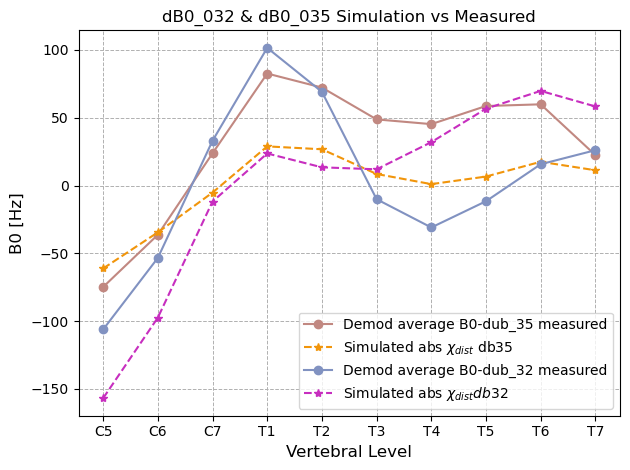

In [27]:
# With that done we can plot them:
vertebrae_levels_joint_opt = ['C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 5 to 14


plt.plot(vertebrae_levels_joint_opt, db0_035_avg_dmod_metric_values, marker = 'o', linestyle = '-', label = "Demod average B0-dub_35 measured", color = "#C18881")
plt.plot(vertebrae_levels_joint_opt, demod_dB0_035_sim_Hz, marker = '*', linestyle = '--', label = r"Simulated abs $\chi_{dist}$ db35", color = "#F1950B")

plt.plot(vertebrae_levels_joint_opt, db0_032_avg_dmod_metric_values, marker = 'o', linestyle = '-', label = "Demod average B0-dub_32 measured", color = "#8192C1")
plt.plot(vertebrae_levels_joint_opt, demod_dB0_032_sim_Hz, marker = '*', linestyle = '--', label = r"Simulated abs $\chi_{dist} db32$", color = "#C72EBF")

title = "dB0_032 & dB0_035 Simulation vs Measured"
plt.title(title)
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()
# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

#yticks = range(-450, 450, 100) 
#plt.yticks(yticks)

# Show the plot
plt.show()

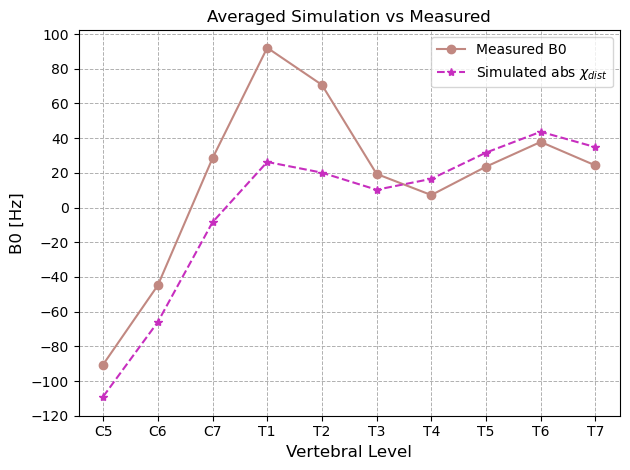

In [28]:
# With that done we can plot them:
vertebrae_levels_joint_opt = ['C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 5 to 14


plt.plot(vertebrae_levels_joint_opt, db0_avg_dmod_B0_meas_values, marker = 'o', linestyle = '-', label = "Measured B0", color = "#C18881")
plt.plot(vertebrae_levels_joint_opt, db0_avg_dmod_B0_sim_values, marker = '*', linestyle = '--', label = r"Simulated abs $\chi_{dist}$", color = "#C72EBF")

title = "Averaged Simulation vs Measured"
plt.title(title)
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()
# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

yticks = range(-120, 120, 20) 
plt.yticks(yticks)

# Show the plot
plt.show()

In [29]:
testing_diff = np.linalg.norm(np.array(db0_avg_dmod_B0_meas_values) - np.array(db0_avg_dmod_B0_sim_values))
print("The initial difference between the averaged measured and simulated values is: ", testing_diff)

The initial difference between the averaged measured and simulated values is:  97.08687742955244


In [32]:
diffs = [(m - s)**2 for m, s in zip(db0_avg_dmod_B0_meas_values, db0_avg_dmod_B0_sim_values)]
l2_norm = (sum(diffs))**0.5
print("The L2 norm manually calculated between the averaged measured and simulated values is: ", l2_norm)

The L2 norm manually calculated between the averaged measured and simulated values is:  97.08687742955244


 # <span style="color:gold"> *Optimization loop!* </span> </br>
 With the graphs working as we expect them too, lets begin chi optimization

In [13]:
history = [] 
history_chi_trachea = []
history_chi_lungs = []

In [14]:
# Loading dependencies outside obj. function to decrease computational needs

# Load the simulated susceptibility map in ppm
sim_chi_img35 = nib.load(path_to_chimap35)
sim_chi_data35 = sim_chi_img35.get_fdata()

# Load segmentation labels that create the chimaps
ROI_img35 = nib.load(path_to_segs35)
ROI_data35 = ROI_img35.get_fdata()

# Find indices with the labels we want to update
ind_trachea35 = np.where((ROI_data35 == 8))
ind_lungs35 = np.where((ROI_data35 == 7))

dmod_sim_mask35 = nib.load(path_to_dmod35_mask).get_fdata()

# Now for dub db0_032
# Load the simulated susceptibility map in ppm
sim_chi_img32 = nib.load(path_to_chimap32)
sim_chi_data32 = sim_chi_img32.get_fdata()

# Load segmentation labels that create the chimaps
ROI_img32 = nib.load(path_to_segs32)
ROI_data32 = ROI_img32.get_fdata()

# Find indices with the labels we want to update
ind_trachea32 = np.where((ROI_data32 == 8))
ind_lungs32 = np.where((ROI_data32 == 7))

dmod_sim_mask32 = nib.load(path_to_dmod32_mask).get_fdata()

# Load the metric mask data for each dub
sim32metric_mask = nib.load(path_to_sim32_metric_mask).get_fdata()
sim35_metric_mask = nib.load(path_to_sim35_metric_mask).get_fdata()

In [15]:
np.unique(sim32metric_mask)

array([ 0.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17.])

In [16]:
np.unique(sim35_metric_mask)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

In [17]:
vertebra_label_map = {"C1": 1, "C2": 2, "C3": 3, "C4": 4, "C5": 5, "C6": 6, "C7": 7, "T1": 8, "T2": 9, "T3": 10, "T4": 11, "T5": 12, "T6": 13, "T7": 14}
vertebrae_subset = ["C5", "C6", "C7", "T1", "T2", "T3", "T4", "T5", "T6", "T7"] # The subset of vertebrae we want to use for the optimization

# With that done we can plot them:
vertebrae_levels_joint_opt = ['C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'] # From 5 to 14

In [42]:
import json, os

best_solution = float('inf')  # Initialize with infinity0
opt_file_path = r"E:\msc_data\ismrm_2025\joint_opt\abstract_figuress"
opt_file_fn = r"E:\msc_data\ismrm_2025\joint_opt\abstract_figuress/log_opt.txt"

if os.path.exists(opt_file_path) and len(os.listdir(opt_file_path)) > 0:
    print("Folder txt_file exists and is not empty. Please delete the folder or choose a different name.")
    sys.exit(1)
else:
    os.makedirs(opt_file_path, exist_ok=True)
    print("Experiment folder created!")

with open(opt_file_fn, 'w') as file:
    file.write("Joint optimization with NOMAD: \n")

Experiment folder created!


In [43]:
def log_solution(counter, chi_trachea, chi_lungs, obj_val):
    global best_solution
    if obj_val <= best_solution:
        if obj_val == best_solution:
            print("Found a solution with the same objective value, but different parameters.")
            with open(opt_file_fn, 'a') as file:
                file.write(f" Iteration #{counter}, Chi trachea: {chi_trachea} & Chi Lung: {chi_lungs}. Obj value: {best_solution} \n")
            return 0

        best_solution = obj_val
        
        with open(opt_file_fn, 'a') as file:
            file.write(f" \n")
            print(f"New best solution: Iteration #{counter}, Chi trachea: {chi_trachea} & Chi Lung: {chi_lungs}. Obj value: {best_solution} ")
        return 1
    
    else:
        print("No improvement in objective value.")
        return 0

In [45]:
def f_simple_double_opt(x):

    global counter # This works? 
    global best_solution
    global dmod_sim_fm_vert_values32, dmod_sim_fm_vert_values35 # Save this to able to plot outside the function
    counter += 1  
    print('$$$$$$$$$$$$$$$$$$$$$$$$$')
    print(f"Iteration #{counter}")
    # COnver the PyNomad Eval Point to list for subscriptions
    chi_trachea =  x.get_coord(0)
    chi_lungs = x.get_coord(1)

    print(f"Chi for trachea: {chi_trachea}")
    print(f"Chi for lungs: {chi_lungs}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")
    
    # Assign variables 
    # Now we get only 1 value 
    #chi_internal_air = 0.27 # ppm in SI units 

    sim_chi_data32[ind_trachea32] = chi_trachea
    sim_chi_data32[ind_lungs32] = chi_lungs
    sim_chi_data35[ind_trachea35] = chi_trachea
    sim_chi_data35[ind_lungs35] = chi_lungs

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist32, image_res32, affine_matrix32 = compute_fieldmap.load_sus_dist(path_to_chimap32)
    chi_dist35, image_res35, affine_matrix35 = compute_fieldmap.load_sus_dist(path_to_chimap35)

    sim_b0_32_ppm =  compute_fieldmap.compute_bz(sim_chi_data32, image_resolution = image_res32, buffer = 50) #, mode = "b0SimISMRM")
    sim_b0_35_ppm =  compute_fieldmap.compute_bz(sim_chi_data35, image_resolution = image_res35, buffer = 50) #, mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_32_Hz = sim_b0_32_ppm * central_freq_db32
    sim_b0_35_Hz = sim_b0_35_ppm * central_freq_db35
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}")))#.replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}")))#.replace(".","_")
    
    ##########################################################################################

    # We won't be creating and saving the maps now because it will be resource intensive
    
    # Now before saving the new fieldmap, lets demodulate with the SC mask
    iter_demod_value32 = np.mean(sim_b0_32_Hz[dmod_sim_mask32 == 1])
    iter_demod_value35 = np.mean(sim_b0_35_Hz[dmod_sim_mask35 == 1])

    print(f"For iteration #{counter} using {iter_demod_value32}")
    print(f"For iteration #{counter} using {iter_demod_value35}")
    demod_iter_fm_32_Hz = sim_b0_32_Hz - iter_demod_value32
    demod_iter_fm_35_Hz = sim_b0_35_Hz - iter_demod_value35


    # Now we extract metrics manually

    dmod_sim_fm_vert_values32 = []
    dmod_sim_fm_vert_values35 = []

    for v in vertebrae_subset:
        label32 = vertebra_label_map[v]
        mask32 = (sim32metric_mask == label32)
        mean_val32 = np.mean(demod_iter_fm_32_Hz[mask32])
        dmod_sim_fm_vert_values32.append(mean_val32)
        # Now for dub 35
        label35 = vertebra_label_map[v]
        mask35 = (sim35_metric_mask == label35)
        mean_val35 = np.mean(demod_iter_fm_35_Hz[mask35])
        dmod_sim_fm_vert_values35.append(mean_val35)

    # After this for loop we have the demodulated simulated fm values for each vertebrae in the subset list C5 to T7
    # Now lets compute the metrics


    difference32_l2 = np.linalg.norm(db0_032_avg_dmod_metric_values - dmod_sim_fm_vert_values32) # This is the L2 norm
    difference35_l2 = np.linalg.norm(db0_035_avg_dmod_metric_values - dmod_sim_fm_vert_values35) # This is the L2 norm
    print("L2 norm for dub db0_032: ", difference32_l2)
    print("L2 nomr for dub db0_035: ", difference35_l2)
    
    joint_difference = difference32_l2 + difference35_l2

    # Track history for convergence
    history.append(joint_difference)
    history_chi_trachea.append(chi_trachea)
    history_chi_lungs.append(chi_lungs)

    objective_value = joint_difference

    plot_sol = log_solution(counter, chi_trachea, chi_lungs, joint_difference)

    if plot_sol:

        plt.clf() # Clear the plot to only have 1 in the output
        
        plt.plot(vertebrae_levels_joint_opt, dmod_sim_fm_vert_values32, marker = 'o', linestyle = '-', label = f"Simulated B0 map - Participant 1", color = "#0C9C1A")  
        plt.plot(vertebrae_levels_joint_opt, db0_032_avg_dmod_metric_values, marker = 'x', linestyle = '--', label = "Measured B0 map - Participant 1", color = "#A02B93") 

        plt.plot(vertebrae_levels_joint_opt, dmod_sim_fm_vert_values35, marker = 'o', linestyle = '-', label = f"Simulated B0 map - Participant 2", color = "#55CE61")  
        plt.plot(vertebrae_levels_joint_opt, db0_035_avg_dmod_metric_values, marker = 'x', linestyle = '--', label = "Measured B0 map - Participant 2", color = "#E79ADE") 


        plt.title(f"Nomad-Optimized $\\chi$ Trachea= {chi1_name} [ppm], $\\chi$ Lung= {chi2_name} [ppm]")

        plt.xlabel('Vertebral Level', fontsize=16)
        plt.ylabel('B0 [Hz]', fontsize=16)
        plt.legend()

        yticks = range(-120, 120, 20) 
        plt.yticks(yticks)

        plt.grid(True, which='both', linestyle='--', linewidth=0.7)
        plt.tight_layout()

        # Show the plot
        plt.show()
        plt.close()

    else:
        print("No improvement, not plotting.")

    
    rawBBO = str(objective_value)
    x.setBBO(rawBBO.encode("UTF-8"))
    return 1


 # <span style="color:#1FC7AB"> *Optimization results!* </span> </br>
 For joint optimization we won't create metric or iterative fieldmaps to reduce computation time!  </br>
 If you repeat the optimization without deleting the log file, it won't show anything unless a better fit is found so take that into account

In [38]:
# Reset counter if neceesary (alone verrsion)
# This should be done when defining new paths but sometimes can be overridden
# Use with care
counter

3

In [40]:
counter = 0
counter

0

In [41]:
import PyNomad as nomad
import time

In [ ]:
# Using optimize minimize from scipy
# \ Set initial values, boundaries and run optimization
initial_values = [-2, -4.2] # 
# First bound is trachea // Depends on objective code !!!
# Second bound is Lung // Depends on objective code !!!
# Check the MD above!
bounds = [(-5, 0.2), (-5, 0.2)]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    
    result = optimize.minimize(f_simple_double_opt, initial_values, bounds = bounds, method = 'Powell')

    # Output the result
    print("Optimization result:", result)
    print("######## ############## ############### #############")

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #1
Chi for trachea: 0.196
Chi for lungs: -2.36
For iteration #1 using -265.9148564495187
For iteration #1 using -296.18364525038646
L2 norm for dub db0_032:  130.2521896289822
L2 nomr for dub db0_035:  166.63705379947965
New best solution: Iteration #1, Chi trachea: 0.196 & Chi Lung: -2.36. Obj value: 296.88924342846184 


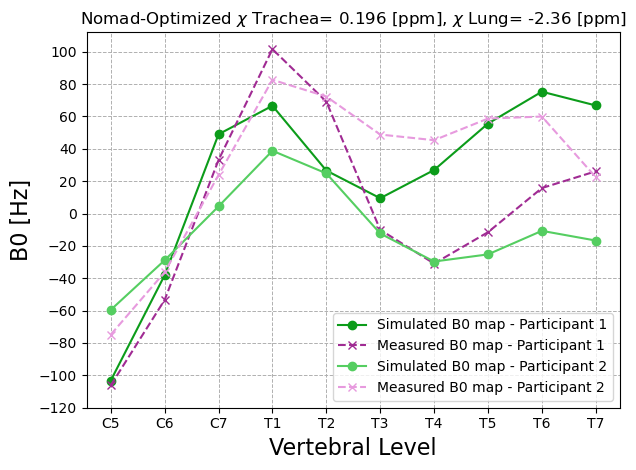

$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #2
Chi for trachea: -0.804
Chi for lungs: -2.36
For iteration #2 using -265.9970102262222
For iteration #2 using -296.2063078735953
L2 norm for dub db0_032:  131.70297485075858
L2 nomr for dub db0_035:  165.94113831531567
No improvement in objective value.
No improvement, not plotting.
$$$$$$$$$$$$$$$$$$$$$$$$$
Iteration #3
Chi for trachea: 0.196
Chi for lungs: -3.36
For iteration #3 using -263.4137374201054
For iteration #3 using -296.34106349718746
L2 norm for dub db0_032:  153.03394103300155
L2 nomr for dub db0_035:  149.27753515356673
No improvement in objective value.
No improvement, not plotting.

NOMAD results 
x_best = [0.196, -2.36]
f_best = 296.88924342846184
h_best = 0.0
nb_evals = 3232223082848
nb_iters = 0
run_flag = 0
stop_reason = Maximum number of blackbox evaluations (Eval Global) 

Optimization complete in: 315.572 seconds


In [46]:
# Using PyNomad for optimization# Using optimize minimize from scipy
# Set initial values, boundaries and run optimization
nomad_params = [
    "DIMENSION 2", 
    "BB_INPUT_TYPE (R R)",
    "BB_OUTPUT_TYPE OBJ",
    "MAX_BB_EVAL 3",
    "DISPLAY_DEGREE 2",
    "DISPLAY_ALL_EVAL false",
    "DISPLAY_STATS BBE OBJ",
    "VNS_MADS_SEARCH true", # Optional Variable Neighborhood Search
    "VNS_MADS_SEARCH_TRIGGER 0.75" # Max desired ration of VNS BBevals over the total number of BBevals
]
x0 = [0.196, -2.36] # 
# First bound is trachea // Depends on objective code !!!
# Second bound is Lung // Depends on objective code !!!
# Check the MD above!
lb = [-10, -5]
ub = [0.27, 0.2]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    start_time = time.time()
    result = nomad.optimize(f_simple_double_opt, x0, lb, ub, nomad_params)
    fmt = ["{} = {}".format(n,v) for (n,v) in result.items()]
    output = "\n".join(fmt)
    print("\nNOMAD results \n" + output + " \n")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Optimization complete in: {elapsed_time:.3f} seconds")

In [ ]:
fmt = ["{} = {}".format(n,v) for (n,v) in result.items()]
output = "\n".join(fmt)
print("\nNOMAD results \n" + output + " \n")

<Figure size 640x480 with 0 Axes>

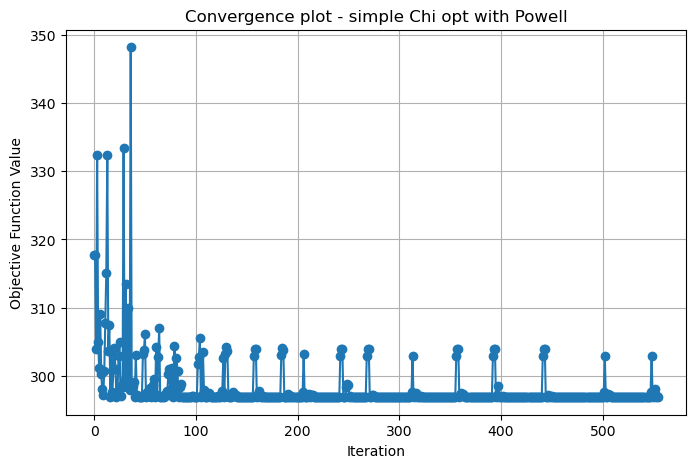

In [83]:
plt.figure()
chi_values_range = np.linspace(-1, 0.5, 100)

plt.figure(figsize=(8, 5))
plt.plot(history, marker='o', linestyle='-')

plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence plot - simple Chi opt with Powell")
plt.grid()
plt.show()

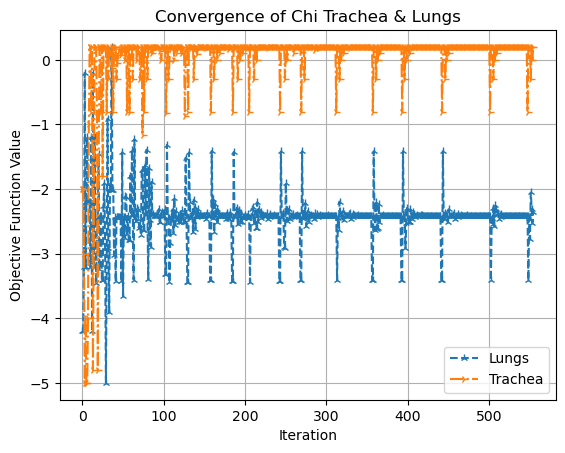

In [84]:
plt.figure()
chi_values_range = np.linspace(-1, 0.5, 100)
plt.plot(history_chi_lungs, marker='2', linestyle='--')
plt.plot(history_chi_trachea, marker='4', linestyle='-.')

plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence of Chi Trachea & Lungs")
plt.legend(["Lungs", "Trachea"])
plt.grid()
plt.show()

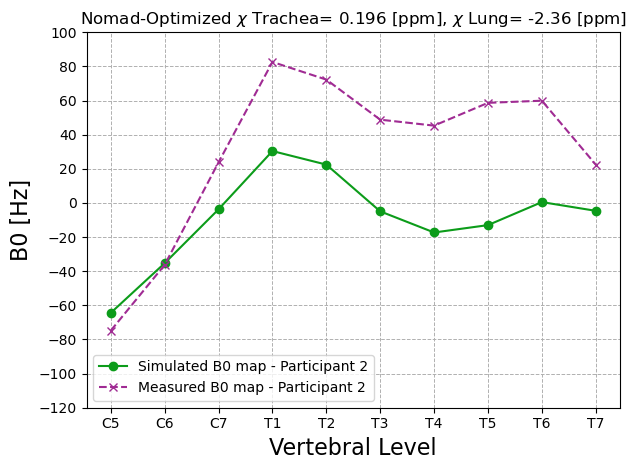

In [49]:
#Plotting outside for each dub:

plt.clf() # Clear the plot to only have 1 in the output
        
#plt.plot(vertebrae_levels_joint_opt, dmod_sim_fm_vert_values32, marker = 'o', linestyle = '-', label = f"Simulated B0 map - Participant 1", color = "#0C9C1A")  
#plt.plot(vertebrae_levels_joint_opt, db0_032_avg_dmod_metric_values, marker = 'x', linestyle = '--', label = "Measured B0 map - Participant 1", color = "#A02B93") 

plt.plot(vertebrae_levels_joint_opt, dmod_sim_fm_vert_values35, marker = 'o', linestyle = '-', label = f"Simulated B0 map - Participant 2", color = "#0C9C1A")  
plt.plot(vertebrae_levels_joint_opt, db0_035_avg_dmod_metric_values, marker = 'x', linestyle = '--', label = "Measured B0 map - Participant 2", color = "#A02B93") 


plt.title(f"Nomad-Optimized $\\chi$ Trachea= {0.196} [ppm], $\\chi$ Lung= {-2.36} [ppm]")

plt.xlabel('Vertebral Level', fontsize=16)
plt.ylabel('B0 [Hz]', fontsize=16)
plt.legend()

yticks = range(-120, 120, 20) 
plt.yticks(yticks)

plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

        # Show the plot
plt.show()
plt.close()

 # <span style="color:#D8C40D6A"> *Metrics!* </span> </br>
 Let's analyze how much we've improved after optimization

In [70]:
worst_l2 = np.max(history)
print("Worst L2 norm: ", worst_l2)
best_l2 = np.min(history)
print("Best L2 norm: ", best_l2)

Worst L2 norm:  nan
Best L2 norm:  nan
